C:\Users\DELL\AppData\Local\Temp\ipykernel_16336\2415196282.py:141: RuntimeWarning: divide by zero encountered in scalar divide
  borrowers["rorac"][p, l] = expected_return / risk_adjusted_capital


Simulation completed!


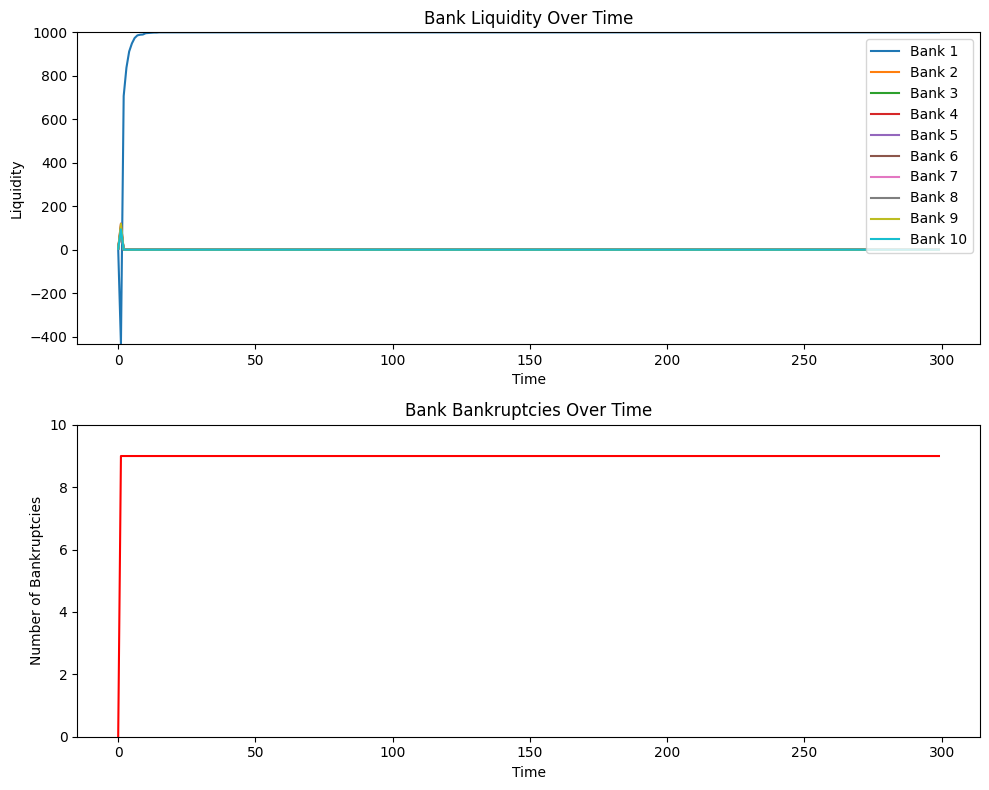

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
t = 300
n_banks = 10
n_households = 1000
n_borrowers = 2000
loan_periods = 1
equity = 5
interest = 0.0125
CAR = 0.01
MRR = 0.035
depo_margin = 0.1
loan_margin = 0.9
recovery_rate = 0.02
withdrawal_prob_min = 0.01
withdrawal_prob_max = 0.1
default_prob_min = 0.1
default_prob_max = 0.8
reserve_fire_sell = 0.8
bankruptcy_fire_sell = 0.5
safety_effect = 0.04
operational_cost = 0.02
rorac_threshold = 0.1  # Threshold for RORAC

# Interest rate shock parameters
interest_shock_TF = True
p_change_interest = 50
interest_delta = 0.005

def concentration_spread(x):
    return 0.15 * x ** 2

def risk_weight(x):
    return 0.5 + 5 * x

# Agent matrices
households = {
    "depo_value": np.ones((t, n_households)),
    "which_bank": np.zeros((t, n_households), dtype=int),
    "withdrawal_prob": np.random.uniform(withdrawal_prob_min, withdrawal_prob_max, (t, n_households))
}
households["which_bank"][0, :] = np.random.choice(n_banks, n_households)

borrowers = {
    "loan_value": np.zeros((t, n_borrowers)),
    "which_bank": np.zeros((t, n_borrowers), dtype=int),
    "pd": np.random.uniform(default_prob_min, default_prob_max, (t, n_borrowers)),
    "recovery_rate": np.full((t, n_borrowers), recovery_rate),
    "risk_weight": np.zeros((t, n_borrowers)),
    "cost_capital": np.zeros((t, n_borrowers)),
    "loan_end": np.random.choice(loan_periods, n_borrowers),
    "rorac": np.zeros((t, n_borrowers))
}
borrowers["which_bank"][0, :] = np.random.choice(n_banks, n_borrowers)

banks = {
    "equity": np.full((t, n_banks), equity),
    "sum_deposits": np.zeros((t, n_banks)),
    "loan_portfolio": np.zeros((t, n_banks)),
    "reserves": np.zeros((t, n_banks)),
    "exp_loss_provision": np.zeros((t, n_banks)),
    "revenue": np.zeros((t, n_banks)),
    "cost": np.zeros((t, n_banks)),
    "income": np.zeros((t, n_banks)),
    "risk_weighted_assets": np.zeros((t, n_banks)),
    "dividends": np.zeros((t, n_banks)),
    "bankruptcy": np.zeros((t, n_banks), dtype=bool),
    "undercapitalized": np.zeros((t, n_banks), dtype=bool),
    "liquidity_assistance": np.zeros((t, n_banks))
}

# Initial values
borrowers["risk_weight"][0, :] = risk_weight(borrowers["pd"][0, :])
for q in range(n_borrowers):
    borrowers["cost_capital"][0, q] = (1 + ((loan_margin + 1) * interest) - borrowers["pd"][0, q] * recovery_rate) / (1 - borrowers["pd"][0, q])
    expected_return = borrowers["cost_capital"][0, q] - borrowers["pd"][0, q] * (1 - recovery_rate)
    risk_adjusted_capital = borrowers["risk_weight"][0, q] * CAR
    borrowers["rorac"][0, q] = expected_return / risk_adjusted_capital

for w in range(n_banks):
    banks["sum_deposits"][0, w] = np.sum(households["depo_value"][0, households["which_bank"][0, :] == w])
    RW_assets = borrowers["risk_weight"][0, borrowers["which_bank"][0, :] == w]
    potential_loans = min(
        int(banks["sum_deposits"][0, w] * (1 - MRR)),
        int((banks["equity"][0, w] / CAR) / np.mean(RW_assets))
    )
    borrower_indices = np.where(borrowers["which_bank"][0, :] == w)[0]
    valid_loans = np.array([i for i in borrower_indices if borrowers["rorac"][0, i] >= rorac_threshold])
    potential_loans = min(potential_loans, len(valid_loans))
    borrowers["loan_value"][0, valid_loans[:potential_loans]] = 1
    banks["loan_portfolio"][0, w] = np.sum(borrowers["loan_value"][0, borrowers["which_bank"][0, :] == w])
    banks["risk_weighted_assets"][0, w] = np.sum(
        borrowers["risk_weight"][0, borrowers["which_bank"][0, :] == w] * borrowers["loan_value"][0, borrowers["which_bank"][0, :] == w]
    )
    banks["exp_loss_provision"][0, w] = np.sum(
        borrowers["pd"][0, borrowers["which_bank"][0, :] == w] * borrowers["loan_value"][0, borrowers["which_bank"][0, :] == w] * (1 - recovery_rate)
    )
    banks["reserves"][0, w] = banks["sum_deposits"][0, w] - banks["loan_portfolio"][0, w]

# Interest rate shock
if interest_shock_TF:
    interest = np.concatenate([
        np.full(p_change_interest - 1, interest),
        np.full(t - p_change_interest + 1, interest + interest_delta)
    ])

# Simulation
for p in range(1, t):
    for u in range(n_households):
        if np.random.rand() < households["withdrawal_prob"][p - 1, u]:
            available_banks = np.where(banks["bankruptcy"][p - 1, :] == 0)[0]
            if len(available_banks) == 0:
                households["which_bank"][p, u] = np.random.choice(n_banks)
            else:
                households["which_bank"][p, u] = np.random.choice(available_banks)
        else:
            households["which_bank"][p, u] = households["which_bank"][p - 1, u]

    for b in range(n_banks):
        banks["sum_deposits"][p, b] = np.sum(households["depo_value"][p, households["which_bank"][p, :] == b])

    borrowers["loan_value"][p, :] = borrowers["loan_value"][p - 1, :]
    for i in np.where(borrowers["loan_value"][p, :] == 1)[0]:
        if np.random.rand() < borrowers["pd"][p, i]:
            borrowers["loan_value"][p, i] = 0

    for r in range(n_banks):
        banks["loan_portfolio"][p, r] = np.sum(borrowers["loan_value"][p, borrowers["which_bank"][p, :] == r])

    for a in range(n_banks):
        banks["exp_loss_provision"][p, a] = np.sum(
            borrowers["pd"][p, borrowers["which_bank"][p, :] == a] * borrowers["loan_value"][p, borrowers["which_bank"][p, :] == a] * (1 - recovery_rate)
        )

    for l in range(n_borrowers):
        borrowers["cost_capital"][p, l] = (1 + ((loan_margin + 1) * interest[p]) - borrowers["pd"][p, l] * recovery_rate) / (1 - borrowers["pd"][p, l])
        expected_return = borrowers["cost_capital"][p, l] - borrowers["pd"][p, l] * (1 - recovery_rate)
        risk_adjusted_capital = borrowers["risk_weight"][p, l] * CAR
        borrowers["rorac"][p, l] = expected_return / risk_adjusted_capital

    for y in range(n_banks):
        banks["revenue"][p, y] = (
            np.sum(borrowers["cost_capital"][p, borrowers["which_bank"][p, :] == y] * borrowers["loan_value"][p, borrowers["which_bank"][p, :] == y]) +
            banks["reserves"][p - 1, y] * interest[p - 1]
        )
        banks["cost"][p, y] = np.sum(households["depo_value"][p - 1, households["which_bank"][p, :] == y] * interest[p] * (1 + depo_margin)) + banks["reserves"][p, y] * operational_cost
        banks["income"][p, y] = banks["revenue"][p, y] - banks["cost"][p, y] - (banks["exp_loss_provision"][p - 1, y] - banks["exp_loss_provision"][p, y])
        banks["equity"][p, y] = banks["equity"][p - 1, y] + banks["income"][p, y]
        banks["reserves"][p, y] = banks["sum_deposits"][p, y] - banks["loan_portfolio"][p, y]

    for k in np.where(banks["equity"][p, :] <= 0)[0]:
        banks["bankruptcy"][p, k] = 1
        for s in np.where(households["which_bank"][p, :] == k)[0]:
            available_banks = np.where(banks["bankruptcy"][p, :] == 0)[0]
            if len(available_banks) == 0:
                households["which_bank"][p, s] = np.random.choice(n_banks)
            else:
                households["which_bank"][p, s] = np.random.choice(available_banks)

# Results Visualization
bank_liquidity = banks["reserves"]
bank_bankruptcy = banks["bankruptcy"]

# Increase plot margins and save to file
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
for i in range(n_banks):
    plt.plot(bank_liquidity[:, i], label=f'Bank {i+1}')
plt.ylim(bank_liquidity.min(), bank_liquidity.max())
plt.ylabel('Liquidity')
plt.xlabel('Time')
plt.title('Bank Liquidity Over Time')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(np.sum(bank_bankruptcy, axis=1), color='red')
plt.ylim(0, n_banks)
plt.ylabel('Number of Bankruptcies')
plt.xlabel('Time')
plt.title('Bank Bankruptcies Over Time')
plt.tight_layout()
plt.savefig('bank_simulation.png')

print("Simulation completed!")
